# Housing Model - Multiple Factors

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
import scipy as sp

In [112]:
# Parameters
lambda_ = 0.85  # lambda parameter for updating house values
n, m = 50, 50  # Grid size

# Define affluence values for rich, middle, and poor
affluence_levels = {
    "rich": 1.0,
    "middle": 0.5,
    "poor": 0.1
}

# Probabilities of rich, middle and poor
p = [0.1, 0.5, 0.4]

# Radius of square neighbourhood
r = 3

rho = 0.4

In [113]:
def random_board(n, m, p, rho):
    """
    Initialize the grids with random affluence levels, house values, and religion.
    """
    # Initialize the affluence grid based on given probabilities
    affluence_grid = np.random.choice(
        [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
        size=(n, m), p=p
    )
    
    # Initialize the house grid with zeros
    house_grid = np.zeros((n, m))  # All house values start as 0
    
    # Initialize the religion grid with binary values (1 or 0) with uniform distribution
    religion_grid = np.random.choice([1, 0], size=(n, m), p=[0.5, 0.5])

    # Initialize the political opinion grid with values (0, 0.5, 1) with some distribution
    #politics_grid = np.random.choice([1, 0.5, 0], size=(n, m), p=[0.25, 0.25, 0.5])

    # Generate a noise matrix
    noise = np.random.rand(n, m)
    # Create the political opinion matrix with correlation to affluence
    continuous_political_grid = rho * affluence_grid + (1-rho) * noise
    
    # Define thresholds for mapping to discrete values to create uniformly distributed opinions (can be adjusted)
    political_grid = np.zeros_like(continuous_political_grid)
    political_grid[continuous_political_grid < 0.33] = 0 # Left
    political_grid[(continuous_political_grid >= 0.33) & (continuous_political_grid < 0.66)] = 0.5 # Center
    political_grid[continuous_political_grid >= 0.66] = 1 # Right
    
    return affluence_grid, house_grid, religion_grid, continuous_political_grid

#### Checking correlation of political opinion and affluence

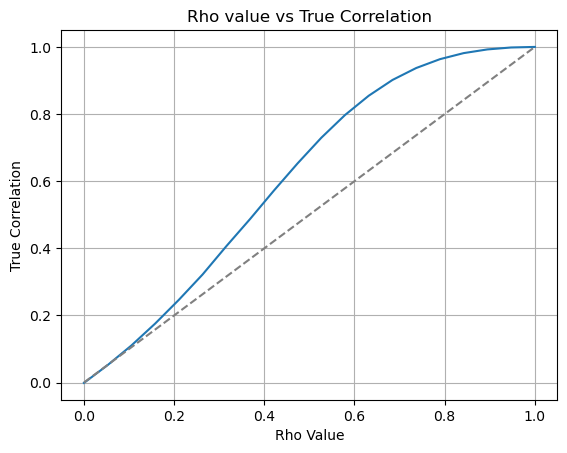

In [114]:
rhos = np.linspace(0, 1, 20)
correlations = []
for rho in rhos:
    corr = 0
    for i in range(200):
        affluence_grid, house_grid, religion_grid, political_grid = random_board(n,m,p, rho)
        # Flatten matrices
        flat1 = affluence_grid.flatten()
        flat2 = political_grid.flatten()
        
        # Compute Pearson correlation
        corr += np.corrcoef(flat1, flat2)[0, 1]
    correlations.append(corr/200)

# Plotting
plt.plot(rhos, correlations)
plt.xlabel('Rho Value')
plt.ylabel('True Correlation')
plt.title('Rho value vs True Correlation')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.grid(True)
plt.show()

In [115]:
def calculate_neighborhood_average(house_grid, x, y, r):
    """
    Calculate the weighted average house value in the square neighborhood of radius r around (x, y),
    with closer neighbours having more weight according to inverse square distance.
    """
    n, m = house_grid.shape    
    weighted_sum = 0
    total_weight = 0
    
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(n, x + r + 1), min(m, y + r + 1)
    
    # Iterate over the neighborhood within the radius
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            # Calculate the distance from (x, y)
            dx, dy = x - i, y - j
            distance_squared = dx**2 + dy**2
            
            # Avoid division by zero by setting a minimum distance
            if distance_squared == 0:
                weight = 1
            else:
                weight = 1 / distance_squared
            
            # Weighted sum and total weight
            weighted_sum += house_grid[i, j] * weight
            total_weight += weight

    # Calculate the weighted average of the neighborhood
    weighted_average = weighted_sum / total_weight
    return weighted_average

In [116]:
def update_values(affluence_grid, house_grid, lambda_, r):
    """
    Update house values based on the affluence and neighborhood average.
    """
    new_house_grid = np.zeros_like(house_grid)
    n, m = house_grid.shape
    for x in range(n):
        for y in range(m):
            affluence = affluence_grid[x, y]
            neighborhood_avg = calculate_neighborhood_average(house_grid, x, y, r)
            new_house_grid[x, y] = affluence + lambda_ * neighborhood_avg
    return new_house_grid

In [117]:
def propose_swap(affluence_grid, house_grid, religion_grid, politics_grid):
    """
    Calculate delta and swap agents if delta > 0.
    """
    n, m = house_grid.shape
    # Choose two random houses
    x1, y1 = random.randint(0, n-1), random.randint(0, m-1)
    x2, y2 = random.randint(0, n-1), random.randint(0, m-1)

    A_x1, A_x2 = affluence_grid[x1, y1], affluence_grid[x2, y2]
    V_x1, V_x2 = house_grid[x1, y1], house_grid[x2, y2]    
    delta_econ = (A_x1 - V_x1)**2 + (A_x2 - V_x2)**2 - (A_x1 - V_x2)**2 - (A_x2 - V_x1)**2

    R_x1, R_x2 = religion_grid[x1, y1], religion_grid[x2, y2]
    R_nbhd_x1, R_nbhd_x2 = calculate_neighborhood_average(religion_grid, x1, y1, r), calculate_neighborhood_average(religion_grid, x2, y2, r)
    delta_rel = (R_x1 - R_nbhd_x1)**2 + (R_x2 - R_nbhd_x2)**2 - (R_x1 - R_nbhd_x2)**2 - (R_x2 - R_nbhd_x1)**2
    
    P_x1, P_x2 = politics_grid[x1, y1], politics_grid[x2, y2]
    P_nbhd_x1, P_nbhd_x2 = calculate_neighborhood_average(politics_grid, x1, y1, r), calculate_neighborhood_average(politics_grid, x2, y2, r)
    delta_pol = (P_x1 - P_nbhd_x1)**2 + (P_x2 - P_nbhd_x2)**2 - (P_x1 - P_nbhd_x2)**2 - (P_x2 - P_nbhd_x1)**2 

    if delta_econ > 0 and 0.5 * delta_rel + 0.5 * delta_pol > 0:
        # Swap the two agents on all grids
        affluence_grid[x1, y1], affluence_grid[x2, y2] = A_x2, A_x1
        house_grid[x1, y1], house_grid[x2, y2] = V_x2, V_x1
        religion_grid[x1, y1], religion_grid[x2, y2] = R_x2, R_x1
        politics_grid[x1, y1], politics_grid[x2, y2] = P_x2, P_x1

#### Simulation

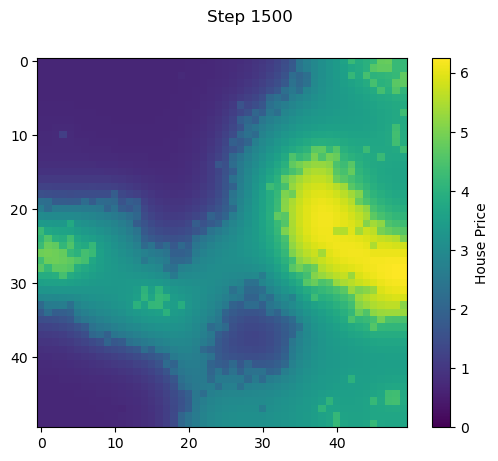

In [120]:
np.random.seed(1234)

# Simulation parameters
n_steps = 1500
affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)

# Set up the plot
fig, ax = plt.subplots()
fig.suptitle('Step 0')

# Set initial color scale to max house price
max_house_price = np.max(house_grid)
img = plt.imshow(house_grid, cmap='viridis', vmin=0, vmax=max_house_price)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')

rich_indices = affluence_grid == 1.0
poor_indices = affluence_grid == 0.1

rich_house_prices = house_grid[rich_indices]
poor_house_prices = house_grid[poor_indices]

avg_prices = [house_grid.mean()]
avg_rich_prices = [rich_house_prices.mean()]
avg_poor_prices = [poor_house_prices.mean()]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    house_grid = update_values(affluence_grid, house_grid, lambda_, r)

    # Propose random move - several in each step
    for i in range(100):
        propose_swap(affluence_grid, house_grid, religion_grid, politics_grid)

    # Calculate new maximum house price for the color scale
    max_house_price = np.max(house_grid)

    rich_indices = affluence_grid == 1.0
    poor_indices = affluence_grid == 0.1
    
    rich_house_prices = house_grid[rich_indices]
    poor_house_prices = house_grid[poor_indices]

    avg_prices.append(house_grid.mean())
    avg_rich_prices.append(rich_house_prices.mean())
    avg_poor_prices.append(poor_house_prices.mean())
    
    # Update image and color scale dynamically
    img.set_array(house_grid)
    img.set_clim(0, max_house_price)  # Update the color scale based on max house price
    fig.suptitle(f"Step {step}")
    
    if step % 20 == 0:
        plt.pause(0.1)
        clear_output(wait=True)
        display(fig)

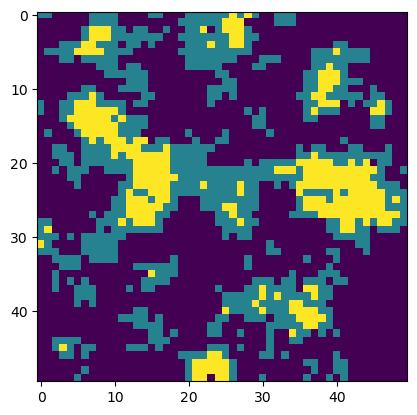

In [8]:
fig, ax = plt.subplots()
fig.suptitle('Affluence')
img = plt.imshow(affluence_grid, cmap='viridis')

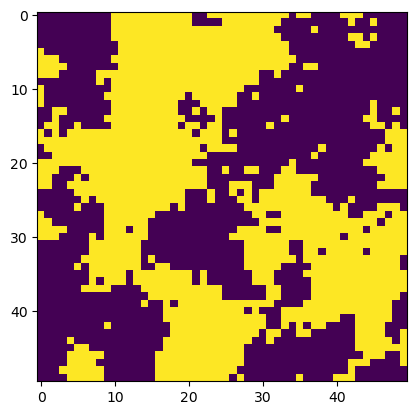

In [8]:
fig, ax = plt.subplots()
fig.suptitle('Religion')
img = plt.imshow(religion_grid, cmap='viridis')

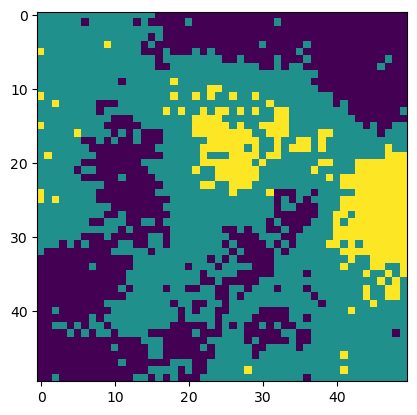

In [9]:
fig, ax = plt.subplots()
fig.suptitle('Political opinion')
img = plt.imshow(politics_grid, cmap='viridis')

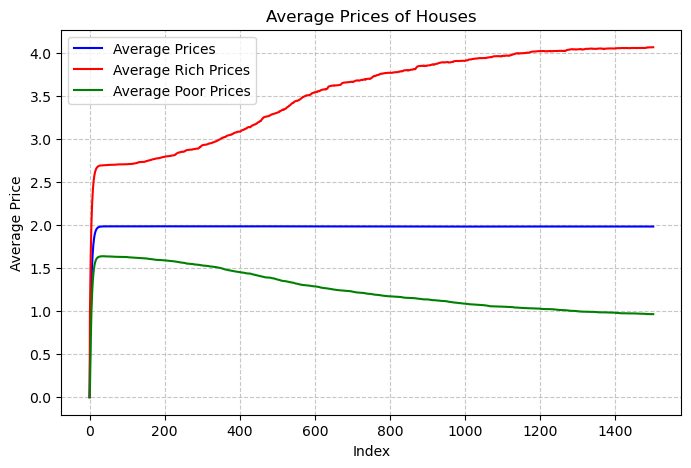

In [10]:
# Create indices for the averages
indices = list(range(len(avg_prices)))

# Plot the averages against their indices
plt.figure(figsize=(8, 5))
plt.plot(indices, avg_prices, linestyle='-', color='b', label="Average Prices")
plt.plot(indices, avg_rich_prices, linestyle='-', color='r', label="Average Rich Prices")
plt.plot(indices, avg_poor_prices, linestyle='-', color='g', label="Average Poor Prices")
plt.title("Average Prices of Houses")
plt.xlabel("Index")
plt.ylabel("Average Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Segregation Index

In [12]:
def spatial_segregation(U):
    m, n = U.shape
    assert m == n, "U (the matrix, not you) must be square" # We could maybe generalise to m != n? But then we'd have to compute our own expected_entropy.

    # Get eigenvals of covariance matrix and apply a normalisation
    Q = U.T @ U # we assume U is real so just use the regular transpose
    eigenvals, _ = np.linalg.eig(Q)
    # keep only real parts (evals should be real but sometimes np accidentally gives a tiny imaginary component).
    # sort eigenvals from largest abs value to smallest, then keep only those that are non zero
    eigenvals = np.array(sorted(np.real(eigenvals), key = abs, reverse = True))
    eigenvals = eigenvals[np.abs(eigenvals) > 1e-5] # get rid of eigenvalues that are basically 0
    p_i_denom = sum(np.abs(eigenvals[1:]))
    p = eigenvals / p_i_denom

    # Measure the entropy and subtract from the expected entropy to get the segregation measure
    H_BO = -sum(p[1:] * np.log(p[1:]))
    expected_entropy = np.log(3/5 * n) # this is given in the text. Although they don't specify natural log, this is closest to actual results
    S_BO = expected_entropy - H_BO

    return S_BO

def theil_index(props):
    """Get the theil index (a measure of inequality) of a vector of n proportions

    Args:
        props (np.ndarray): Proportions (must sum to around 1)

    Returns:
        float: Theil index of given distribution
    """
    assert all(props >= 0), "Proportions should all be non-negative"
    assert np.abs(np.sum(props) - 1) < 1e-5, "Proportions should sum to 1 (modulo some rounding errors)"
    return np.log(len(props)) + np.sum(props * np.log(props))

def generate_unequal_props(eta: float):
    """Generate a vector of 3 proportions using the 1 parameter family 5.1 from Aguilera et al 2007. You can
    then multiply these proportions by your total number of agents to get the desired number of agents in each group.

    Args:
        eta (float): A parameter between 0.5 and 1 (exclusive), used to generate the proportions. A higher eta corresponds to a higher Theil index.

    Returns:
        props: A 3d vector of proportions, proportion poor, middle, and rich (in that order).
        ti: The Theil index corresponding to the above vector
    """
    assert 0.5 < eta < 1, "Eta must be between 0.5 and 1 (exclusive)"

    a = 0.4 # this is the fixed value used throughout section 5 of Aguilera
    props = np.array([eta, (1-a)*(1-eta), a*(1-eta)])
    ti = theil_index(props)

    return props, ti

i=0, eta=0.501


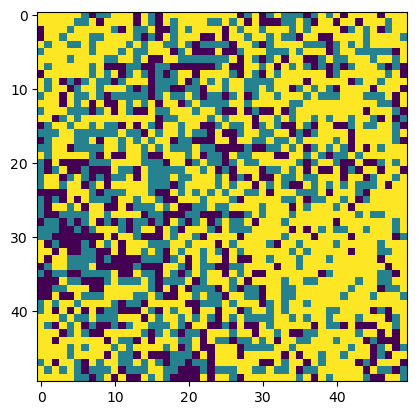

i=1, eta=0.5508888888888889


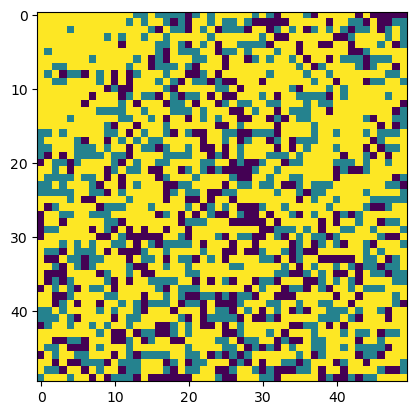

i=2, eta=0.6007777777777777


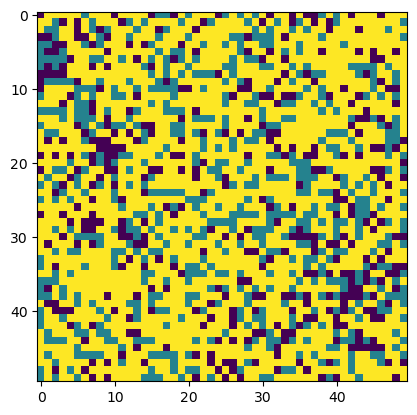

i=3, eta=0.6506666666666667


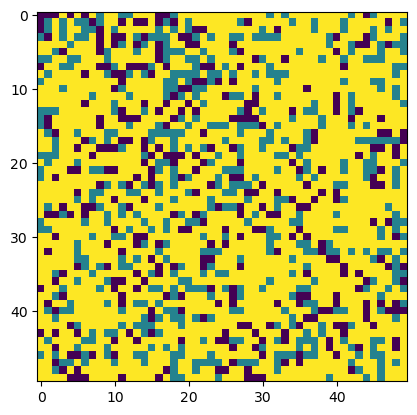

i=4, eta=0.7005555555555556


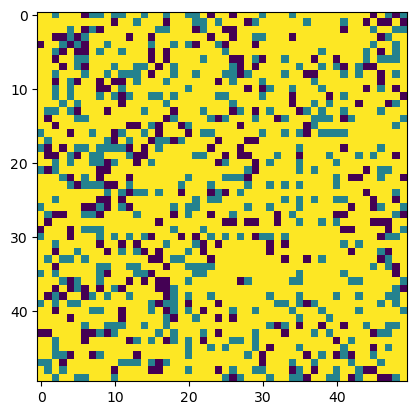

i=5, eta=0.7504444444444445


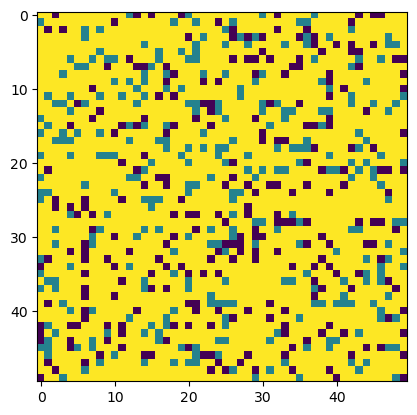

i=6, eta=0.8003333333333333


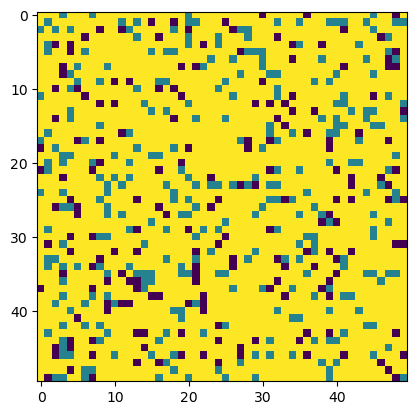

i=7, eta=0.8502222222222222


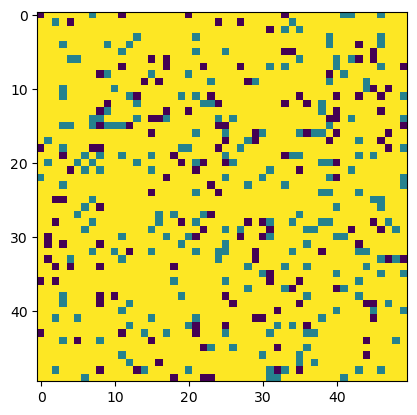

i=8, eta=0.9001111111111111


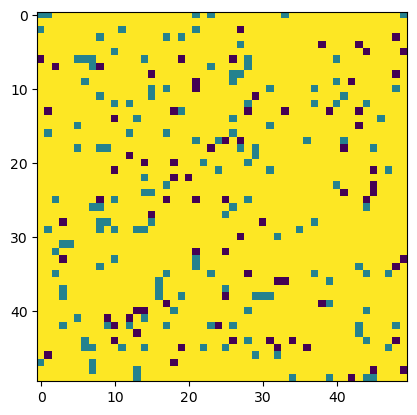

i=9, eta=0.95


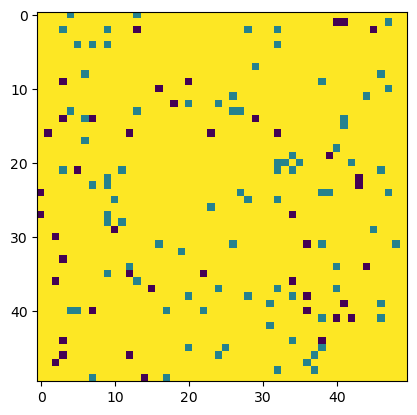

In [105]:
# We're going to collect 10 data points
n_simulations = 10
etas = np.linspace(0.501, 0.95, n_simulations)
theil_indices = np.zeros(n_simulations)
segregation_indices = np.zeros(n_simulations)

for i, eta in enumerate(etas):
    print(f"{i=}, {eta=}") # for debugging
    p, theil_indices[i] = generate_unequal_props(eta)
    affluence_grid, house_grid, religion_grid, political_grid = random_board(n, m, p, rho)

    # Simulation loop
    for step in range(100):
        # Update house values
        house_grid = update_values(affluence_grid, house_grid, lambda_, r)
        
        # Propose random move - several in each step
        for j in range(100):
            propose_swap(affluence_grid, house_grid, religion_grid, political_grid)

    plt.imshow(affluence_grid)
    plt.show()
    
    segregation_indices[i] = spatial_segregation(affluence_grid)

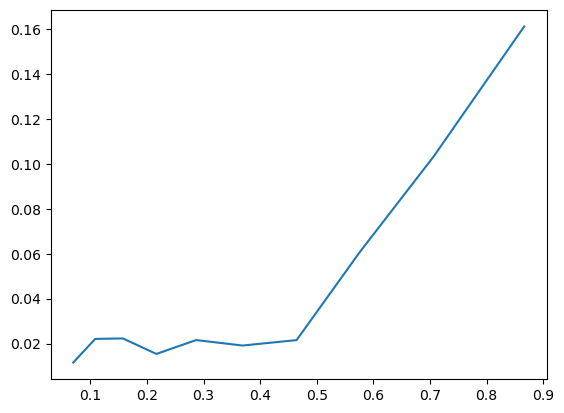

In [106]:
plt.plot(theil_indices, segregation_indices)

#### Segregation over time

In [93]:
# Simulation parameters
n_steps = 1500
affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)
seg_indices=[]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    house_grid = update_values(affluence_grid, house_grid, lambda_, r)

    # Propose random move - several in each step
    for i in range(100):
        propose_swap(affluence_grid, house_grid, religion_grid, politics_grid)
        
    seg_ind = spatial_segregation(house_grid)
    seg_indices.append(seg_ind)

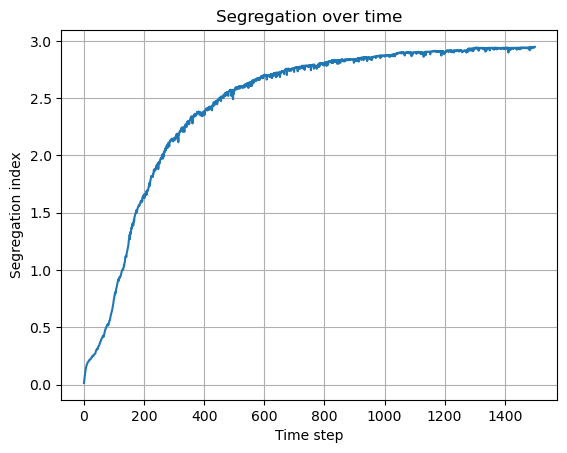

In [94]:
indices = list(range(len(seg_indices)))
plt.plot(indices, seg_indices)
plt.xlabel('Time step')
plt.ylabel('Segregation index')
plt.title('Segregation over time')
plt.grid(True)
plt.show()

#### If n_steps * swap_nr = constant

n_steps: 50, swap_nr: 200, Avg Segregation Index: 0.3108
n_steps: 80, swap_nr: 125, Avg Segregation Index: 0.2943
n_steps: 100, swap_nr: 100, Avg Segregation Index: 0.3145
n_steps: 125, swap_nr: 80, Avg Segregation Index: 0.3257
n_steps: 200, swap_nr: 50, Avg Segregation Index: 0.3286
n_steps: 250, swap_nr: 40, Avg Segregation Index: 0.3287
n_steps: 400, swap_nr: 25, Avg Segregation Index: 0.3304
n_steps: 500, swap_nr: 20, Avg Segregation Index: 0.3857


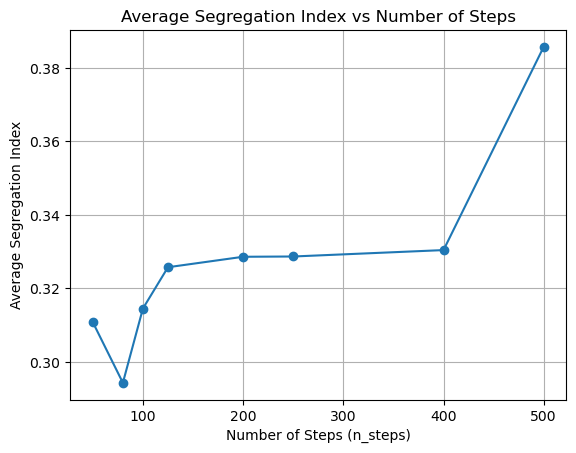

In [104]:
total_swaps = 10000
# Test different combinations of n_steps and swap_nr
combinations = [(50, total_swaps // 50),
                (80, total_swaps // 80),
                (100, total_swaps // 100), 
                (125, total_swaps // 125),
                (200, total_swaps // 200),
                (250, total_swaps // 250),
                (400, total_swaps // 400),
                (500, total_swaps // 500)]

average_segregation_indices = []

# Iterate over different combinations
for n_steps, swap_nr in combinations:
    seg_indices = []

    for j in range(10):  # Repeat experiment 10 times for averaging
        # Initialize random board
        affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)
        
        # Simulation loop
        for step in range(n_steps + 1):
            # Update house values
            house_grid = update_values(affluence_grid, house_grid, lambda_, r)
            
            # Propose random moves (swap_nr times per step)
            for i in range(swap_nr):
                propose_swap(affluence_grid, house_grid, religion_grid, politics_grid)
        
        # Compute segregation index
        seg_ind = spatial_segregation(house_grid)
        seg_indices.append(seg_ind)
    
    # Compute average segregation index for this combination
    avg_seg_ind = np.mean(seg_indices)
    average_segregation_indices.append(avg_seg_ind)
    print(f"n_steps: {n_steps}, swap_nr: {swap_nr}, Avg Segregation Index: {avg_seg_ind:.4f}")

# Plot results
n_steps_list = [combo[0] for combo in combinations]

plt.plot(n_steps_list, average_segregation_indices, marker='o')
plt.xlabel('Number of Steps')
plt.ylabel('Average Segregation Index')
plt.title('Average Segregation Index vs Number of Steps')
plt.grid(True)
plt.show()

#### Segregation over time + error bars (std)

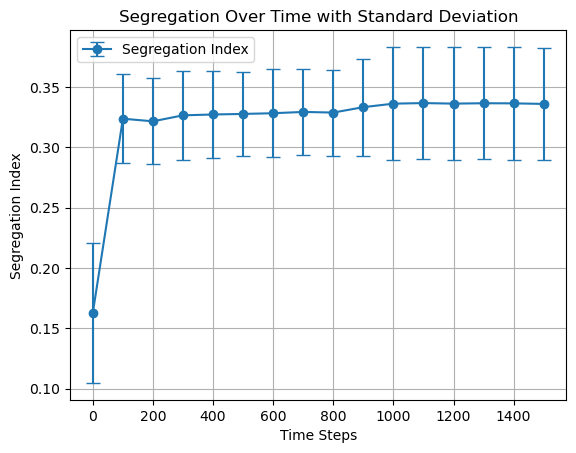

In [109]:
# Simulation parameters
n_steps = 1500
step_interval = 100  # Record segregation index every 100 steps
n_time_points = n_steps // step_interval + 1
n_experiments = 10

seg_indices = np.zeros((n_experiments, n_time_points))

for j in range(n_experiments):
    # Initialize random board
    affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)
    
    # Simulation loop
    for step in range(n_steps + 1):
        # Update house values
        house_grid = update_values(affluence_grid, house_grid, lambda_, r)
        
        # Propose random swaps
        for i in range(100):
            propose_swap(affluence_grid, house_grid, religion_grid, politics_grid)
        
        # Record segregation index every 100 steps
        if step % step_interval == 0:
            seg_ind = spatial_segregation(house_grid)
            seg_indices[j][step // step_interval] = seg_ind

# Calculate mean and standard deviation of segregation indices
mean_seg = np.mean(seg_indices, axis=0)
std_seg = np.std(seg_indices, axis=0)

# Time points corresponding to recorded steps
time_points = np.arange(0, n_steps + 1, step_interval)

# Plotting with error bars
plt.errorbar(time_points, mean_seg, yerr=std_seg, fmt='-o', capsize=5, label='Segregation Index')
plt.xlabel('Time Steps')
plt.ylabel('Segregation Index')
plt.title('Segregation Over Time with Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()